In [1]:
import pandas as pd
df = pd.read_csv('../data/super_processed/6_df_air_data_and_locations_reduced.csv')

In [3]:
!pip install nbformat

In [15]:
import pandas as pd
import altair as alt

# Filtrar datos para los id_no2 especificados
ids_no2 = [28079035, 28079050, 28079056]
filtered_df = df[df['id_no2'].isin(ids_no2)].copy()

# Agregar columna de grupo temporal
filtered_df['time_group'] = pd.to_datetime(filtered_df['fecha']).dt.to_period('M').dt.to_timestamp()

# Eliminar datos del último mes
ultimo_mes = filtered_df['time_group'].max()
filtered_df = filtered_df[filtered_df['time_group'] < ultimo_mes]

# Calcular estadísticas por grupo temporal
stats_df = filtered_df.groupby(['time_group', 'id_no2']).agg(
    no2_promedio=('no2_value', 'mean'),
    no2_max=('no2_value', 'max'),
    num_readings=('no2_value', 'count')
).reset_index()
stats_df['id_no2'] = stats_df['id_no2'].astype(str)

# Datos originales sin los sensores seleccionados
df_original = df[~df['id_no2'].isin(ids_no2)].copy()
df_original['time_group'] = pd.to_datetime(df_original['fecha']).dt.to_period('M').dt.to_timestamp()
df_original = df_original[df_original['time_group'] < ultimo_mes]

# Calcular promedio general
general_mean_df = df_original.groupby('time_group').agg(
    no2_promedio=('no2_value', 'mean')
).reset_index()
general_mean_df['id_no2'] = 'Promedio general'

# Paleta armónica y clara
color_scale = alt.Scale(
    domain=['28079056', '28079050', '28079035', 'Promedio general'],
    range=['#1f77b4', '#ff7f0e', '#2ca02c', 'black']  # azul, naranja, verde, negro
)

# Crear gráfico
def show_temporal_evolution(stats_df, general_mean_df):
    print("**Evolución temporal de NO₂**")
    print("La OMS recomienda que los niveles medios anuales de NO₂ no superen los 40 μg/m³ (línea roja).")

    # Gráfico de líneas por sensor
    sensors_chart = alt.Chart(stats_df).mark_line(point=alt.OverlayMarkDef(size=30)).encode(
        x=alt.X('time_group:T', title='Fecha', axis=alt.Axis(labelAngle=-45, grid=False)),
        y=alt.Y('no2_promedio:Q', title='NO₂ promedio (μg/m³)', axis=alt.Axis(grid=False)),
        color=alt.Color('id_no2:N', title='Sensor', scale=color_scale,
                        legend=alt.Legend(
                            orient='top',
                            labelFontSize=14,
                            titleFontSize=16
                        )),
        tooltip=[
            alt.Tooltip('time_group:T', title='Fecha'),
            alt.Tooltip('no2_promedio:Q', title='NO₂ promedio', format='.1f'),
            alt.Tooltip('id_no2:N', title='Sensor')
        ]
    )

    # Línea de promedio general
    general_chart = alt.Chart(general_mean_df).mark_line(
        point=True, strokeDash=[4, 4]
    ).encode(
        x='time_group:T',
        y='no2_promedio:Q',
        color=alt.Color('id_no2:N', scale=color_scale),
        tooltip=[
            alt.Tooltip('time_group:T', title='Fecha'),
            alt.Tooltip('no2_promedio:Q', title='Promedio general', format='.1f')
        ]
    )


    return (sensors_chart + general_chart).properties(
        width=1200,
        height=400,
        title=alt.TitleParams(
            text="Evolución temporal de NO₂ por sensor",
            fontSize=24,
            fontWeight='bold',
            anchor='middle'
        )
    ).configure(
        background='white',
        axis=alt.AxisConfig(labelFontSize=13, titleFontSize=15),
        legend=alt.LegendConfig(labelFontSize=14, titleFontSize=16),
        title=alt.TitleConfig(font='Helvetica', anchor='middle')
    )

# Mostrar gráfico
graph = show_temporal_evolution(stats_df, general_mean_df)
graph


**Evolución temporal de NO₂**
La OMS recomienda que los niveles medios anuales de NO₂ no superen los 40 μg/m³ (línea roja).


alt.LayerChart(...)

In [17]:
df.drop(columns=['longitud','latitud'])

,id_no2,fecha,no2_value
0,28079004,2018-01-01 01:00:00,15.0
1,28079004,2018-01-01 02:00:00,35.0
2,28079004,2018-01-01 03:00:00,29.0
3,28079004,2018-01-01 04:00:00,16.0
4,28079004,2018-01-01 05:00:00,12.0
...,...,...,...
1428078,28079060,2024-11-30 20:00:00,58.0
1428079,28079060,2024-11-30 21:00:00,61.0
1428080,28079060,2024-11-30 22:00:00,66.0
1428081,28079060,2024-11-30 23:00:00,77.0


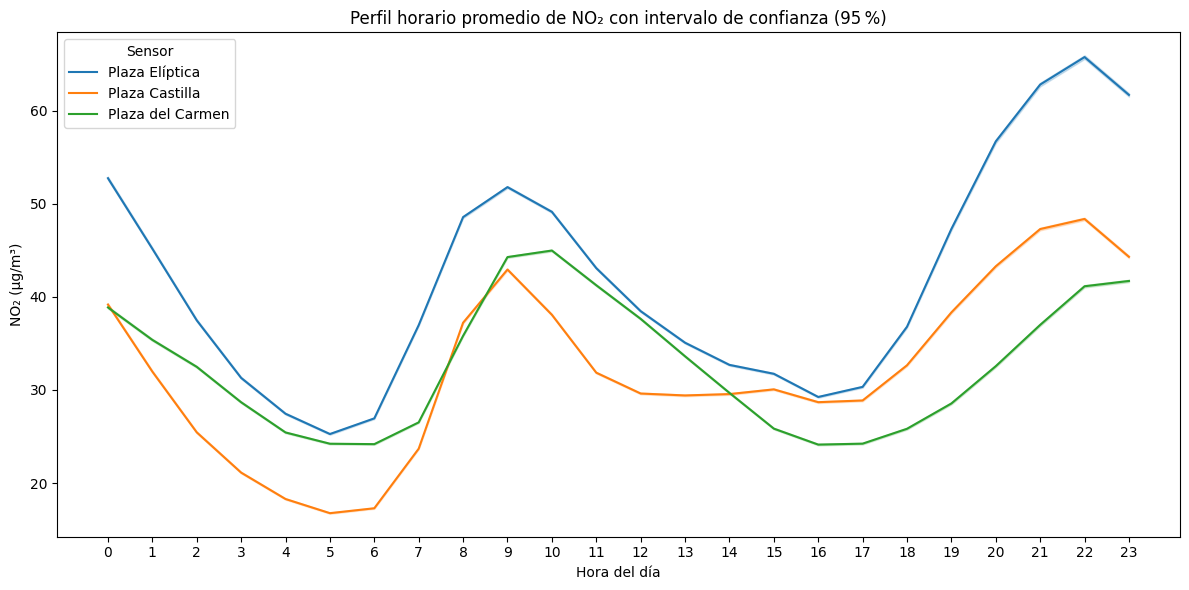

In [24]:
# Reimportar todo tras reinicio del entorno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
df['id_no2'] = df['id_no2'].astype(int)

# Filtrar sensores y crear variables temporales
sensores_interes = [28079056, 28079050, 28079035]
nombres_sensores = {
    28079056: 'Plaza Elíptica',
    28079050: 'Plaza Castilla',
    28079035: 'Plaza del Carmen'
}

df_filtrado = df[df['id_no2'].isin(sensores_interes)].copy()
df_filtrado['nombre_sensor'] = df_filtrado['id_no2'].map(nombres_sensores)
df_filtrado['hora'] = df_filtrado['fecha'].dt.hour

# Perfil horario con media, desviación estándar e IC 95%
perfil_horario = df_filtrado.groupby(['nombre_sensor', 'hora'])['no2_value'].agg(['mean', 'std']).reset_index()
perfil_horario['ci95'] = 1.96 * (perfil_horario['std'] / np.sqrt(len(df_filtrado)))

# Plot: Media horaria con banda de confianza del 95 %
plt.figure(figsize=(12, 6))
colores = {'Plaza Elíptica': '#1f77b4', 'Plaza Castilla': '#ff7f0e', 'Plaza del Carmen': '#2ca02c'}

for sensor in colores:
    data = perfil_horario[perfil_horario['nombre_sensor'] == sensor]
    plt.plot(data['hora'], data['mean'], label=sensor, color=colores[sensor])
    plt.fill_between(data['hora'], data['mean'] - data['ci95'], data['mean'] + data['ci95'], color=colores[sensor], alpha=0.2)

plt.title("Perfil horario promedio de NO₂ con intervalo de confianza (95 %)")
plt.xlabel("Hora del día")
plt.ylabel("NO₂ (µg/m³)")
plt.legend(title="Sensor")
plt.xticks(range(0, 24))
plt.grid(False)
plt.tight_layout()
plt.show()


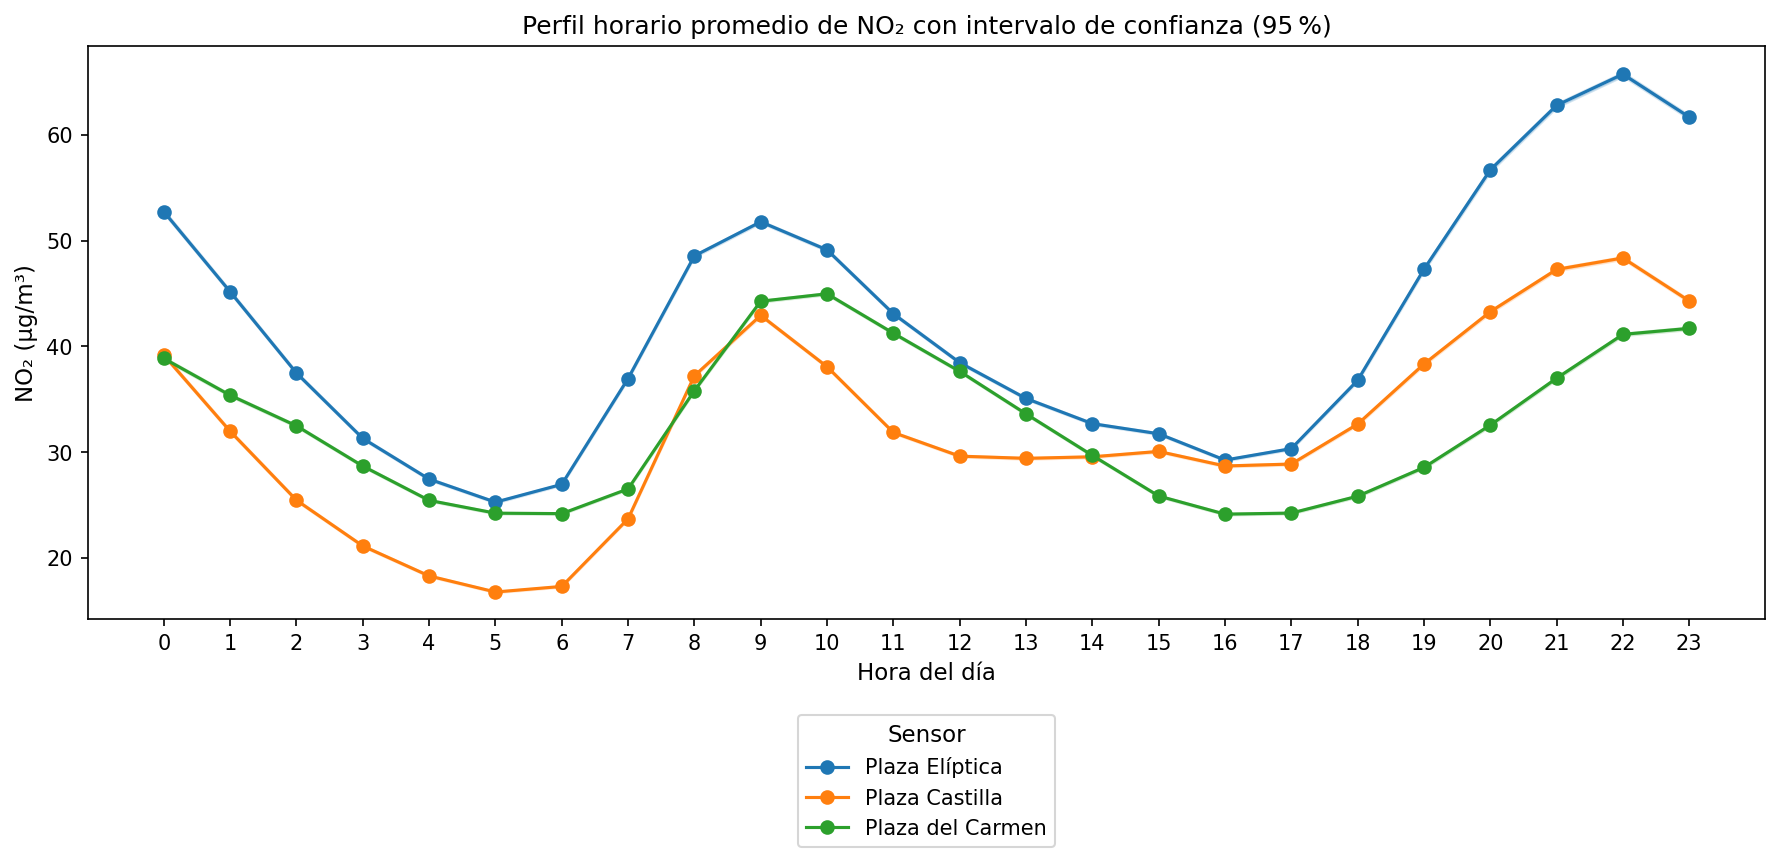

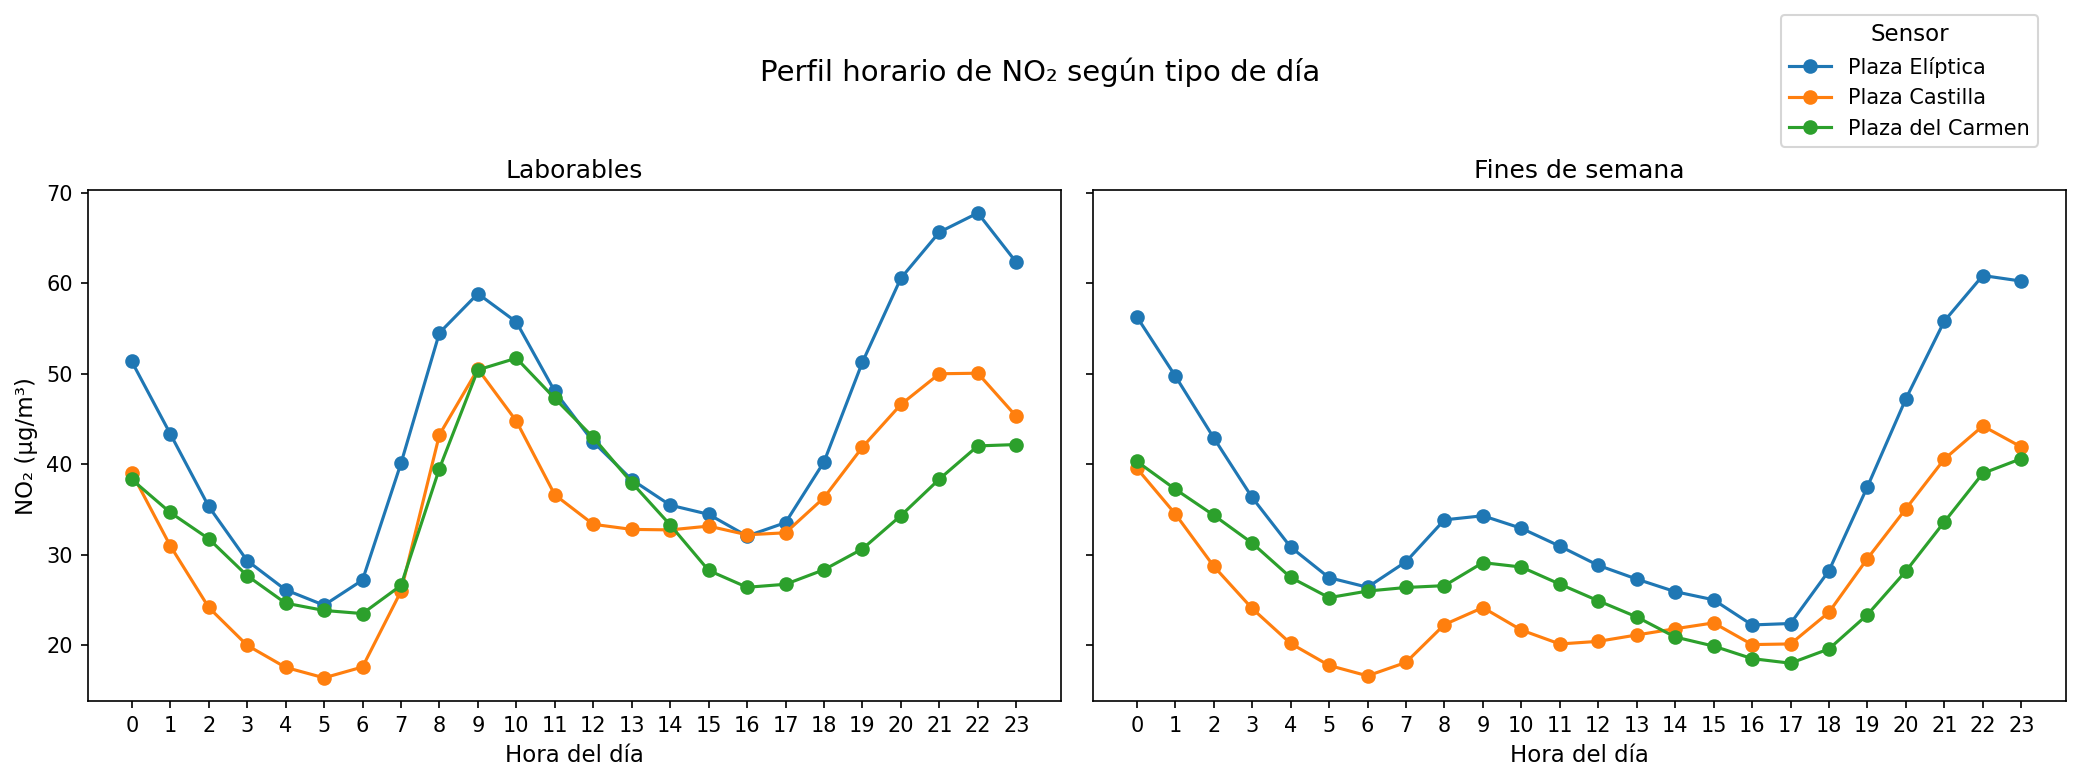

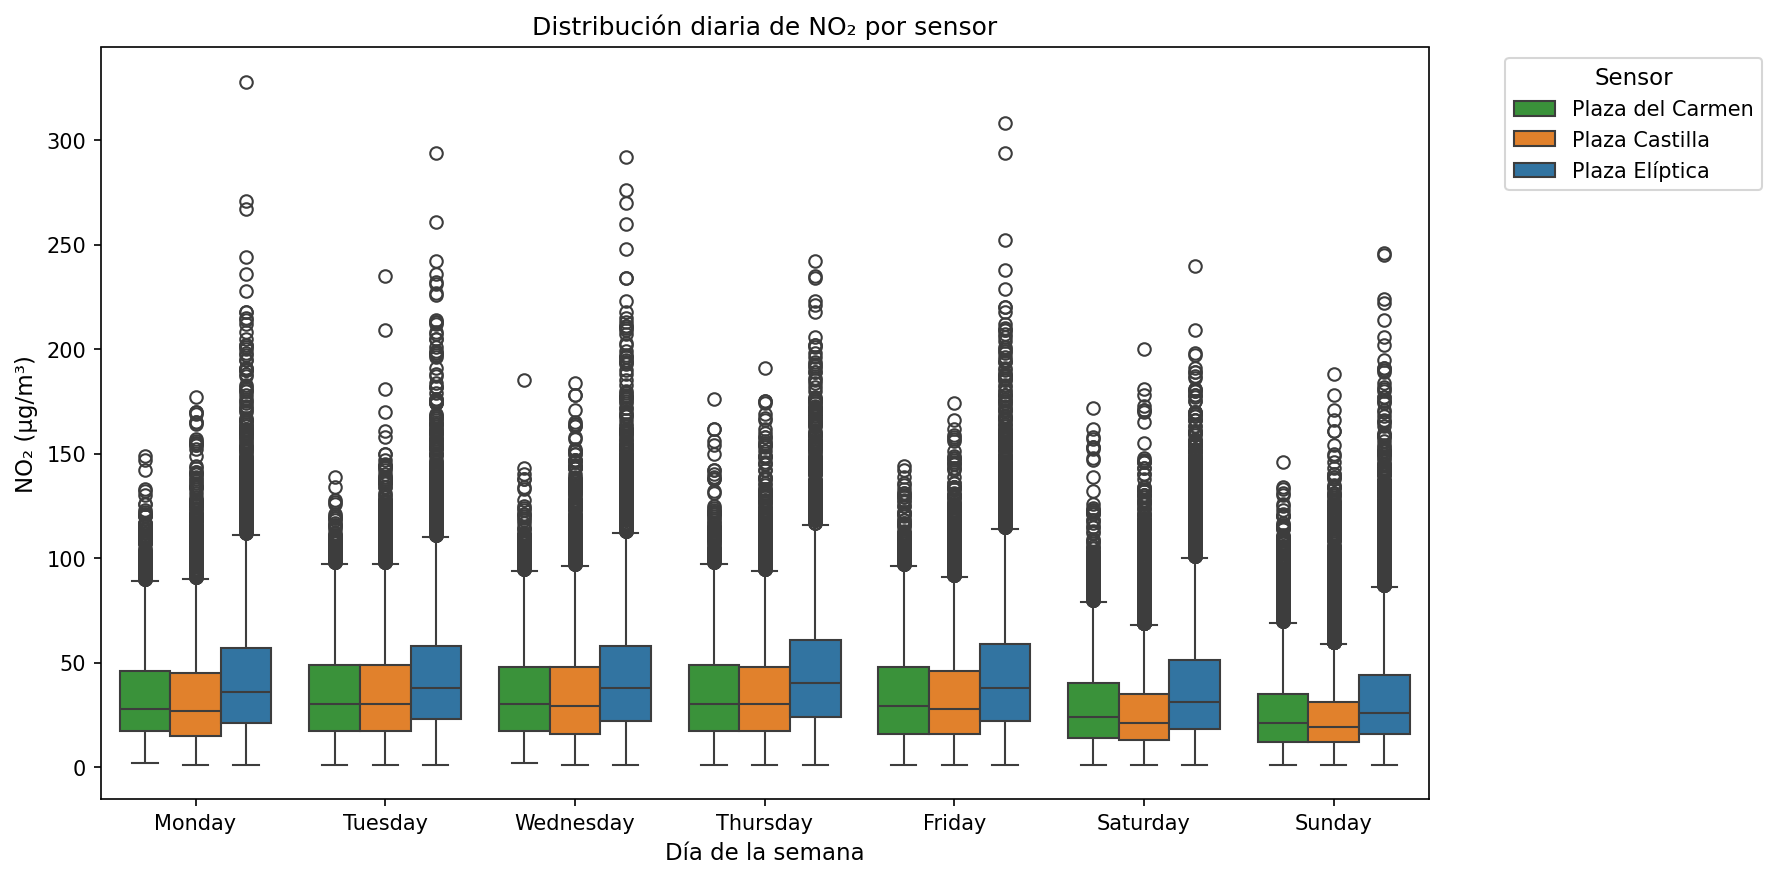

In [51]:
# Cargar dependencias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Filtro y nombres
sensores_interes = [28079056, 28079050, 28079035]
nombres_sensores = {
    28079056: 'Plaza Elíptica',
    28079050: 'Plaza Castilla',
    28079035: 'Plaza del Carmen'
}
colores = {'Plaza Elíptica': '#1f77b4', 'Plaza Castilla': '#ff7f0e', 'Plaza del Carmen': '#2ca02c'}

# Crear DataFrame filtrado y variables temporales
df_filtrado = df[df['id_no2'].isin(sensores_interes)].copy()
df_filtrado['nombre_sensor'] = df_filtrado['id_no2'].map(nombres_sensores)
df_filtrado['hora'] = df_filtrado['fecha'].dt.hour
df_filtrado['dia_semana'] = df_filtrado['fecha'].dt.dayofweek
df_filtrado['fin_de_semana'] = df_filtrado['dia_semana'].isin([5, 6])
df_filtrado['nombre_dia'] = pd.Categorical(df_filtrado['fecha'].dt.day_name(),
                                           categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                           ordered=True)

# 1. Perfil horario promedio + IC 95%
perfil_horario = df_filtrado.groupby(['nombre_sensor', 'hora'])['no2_value'].agg(['mean', 'std']).reset_index()
perfil_horario['ci95'] = 1.96 * (perfil_horario['std'] / np.sqrt(len(df_filtrado)))

plt.figure(figsize=(12, 6))
for sensor in colores:
    data = perfil_horario[perfil_horario['nombre_sensor'] == sensor]
    plt.plot(data['hora'], data['mean'], label=sensor, color=colores[sensor], marker='o')
    plt.fill_between(data['hora'].values,
                     (data['mean'] - data['ci95']).values,
                     (data['mean'] + data['ci95']).values,
                     color=colores[sensor], alpha=0.2)
plt.title("Perfil horario promedio de NO₂ con intervalo de confianza (95 %)")
plt.xlabel("Hora del día")
plt.ylabel("NO₂ (µg/m³)")
plt.legend(title="Sensor", loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.xticks(range(0, 24))
plt.grid(False)
plt.tight_layout()
plt.show()

# 2. Comparación días laborables vs. fines de semana
df_laboral_vs_fdsem = df_filtrado.groupby(['nombre_sensor', 'hora', 'fin_de_semana'])['no2_value'].mean().reset_index()
# Usar colores distintos a los anteriores para distinguir laboral vs. fin de semana
colores_laboral_fdsem = {False: '#9467bd', True: '#8c564b'}  # púrpura y marrón
titulos_colores = {'Plaza Elíptica': '#1f77b4', 'Plaza Castilla': '#ff7f0e', 'Plaza del Carmen': '#2ca02c'}

# Separar los datos: días laborables (False) y fines de semana (True)
df_laboral = df_laboral_vs_fdsem[df_laboral_vs_fdsem['fin_de_semana'] == False]
df_fdsem = df_laboral_vs_fdsem[df_laboral_vs_fdsem['fin_de_semana'] == True]

# Asignar colores por estación
color_sensores = {'Plaza Elíptica': '#1f77b4', 'Plaza Castilla': '#ff7f0e', 'Plaza del Carmen': '#2ca02c'}

# Crear figura con subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Datos y colores
color_sensores = {'Plaza Elíptica': '#1f77b4', 'Plaza Castilla': '#ff7f0e', 'Plaza del Carmen': '#2ca02c'}
# Crear figura con subplots


# Gráfico 1: días laborables
for sensor in color_sensores:
    data = df_laboral[df_laboral['nombre_sensor'] == sensor]
    axes[0].plot(data['hora'], data['no2_value'], label=sensor, color=color_sensores[sensor], marker='o')
axes[0].set_title("Laborables")
axes[0].set_xlabel("Hora del día")
axes[0].set_ylabel("NO₂ (µg/m³)")
axes[0].set_xticks(range(0, 24))
axes[0].grid(False)

# Gráfico 2: fines de semana
for sensor in color_sensores:
    data = df_fdsem[df_fdsem['nombre_sensor'] == sensor]
    axes[1].plot(data['hora'], data['no2_value'], label=sensor, color=color_sensores[sensor], marker='o')
axes[1].set_title("Fines de semana")
axes[1].set_xlabel("Hora del día")
axes[1].set_xticks(range(0, 24))
axes[1].grid(False)

# Leyenda común en la parte superior derecha
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Sensor", loc='upper right', bbox_to_anchor=(0.98, 1.05))

# Título general
fig.suptitle("Perfil horario de NO₂ según tipo de día", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



#3. la semana
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtrado, x='nombre_dia', y='no2_value', hue='nombre_sensor',
            palette=colores)
plt.title("Distribución diaria de NO₂ por sensor")
plt.xlabel("Día de la semana")
plt.ylabel("NO₂ (µg/m³)")
plt.legend(title="Sensor", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [52]:
df = pd.read_parquet('../data/super_processed/7_4_no2_with_traffic_and_1meteo_and_1trafic_id.parquet')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736070 entries, 0 to 736069
Data columns (total 53 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id_no2              736070 non-null  object        
 1   fecha               736070 non-null  datetime64[ns]
 2   no2_value           736070 non-null  float64       
 3   latitud_no2         736070 non-null  float64       
 4   longitud_no2        736070 non-null  float64       
 5   id_trafico          736070 non-null  object        
 6   distance_m          736070 non-null  float64       
 7   latitud_trafico     736070 non-null  float64       
 8   longitud_trafico    736070 non-null  float64       
 9   intensidad          736070 non-null  float64       
 10  carga               736070 non-null  float64       
 11  ocupacion           736070 non-null  float64       
 12  vmed                736070 non-null  float64       
 13  latitud_meteo       736070 no

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CONFIGURAR
meteo_vars   = ['d2m', 't2m', 'ssr', 'ssrd', 'u10', 'v10', 'sp', 'tp', 'wind_speed']
traf_vars    = ['intensidad', 'carga', 'ocupacion', 'vmed']
lag_vars_int = [f'intensidad_lag{k}' for k in [1,2,4, 6, 8]]
lag_vars_ocu = [f'ocupacion_lag{k}'  for k in [1,2,4, 6, 8]]
lag_vars_car = [f'carga_lag{k}'      for k in [1,2,4, 6, 8]]
all_numeric  = ['no2_value'] + meteo_vars + traf_vars + lag_vars_int + lag_vars_ocu + lag_vars_car

sns.set(style="whitegrid", font_scale=1.15)

# ---------------------------
# Funciones auxiliares
# ---------------------------
def aggregate_df(df, freq):
    """Agrupa por sensor y frecuencia temporal usando la media."""
    return (df
            .set_index('fecha')
            .groupby('id_no2')
            .resample(freq)
            .mean(numeric_only=True)
            .reset_index())

def corr_heatmap(df, vars_, title):
    """Dibuja heat-map y muestra correlaciones numéricas por consola."""
    corr = df[vars_].corr()
    
    # → Impresión en consola
    print('\n' + '='*60)
    print(title.upper())
    print(corr['no2_value'].drop('no2_value').sort_values(key=abs, ascending=False))
    print('='*60 + '\n')
    
    # → Figura
    #mask = np.triu(np.ones_like(corr, dtype=bool))
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)
    #plt.figure(figsize=(10, 8))
    #sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt='.2f',
    #            linewidths=.5, cbar_kws={'shrink': .8})
    #plt.title(title)
    #plt.tight_layout()
    #plt.show()

def run_correlations(df, freq_label, freq_code):
    
    if freq_code is not None:
        agg = aggregate_df(df, freq_code)
    else:                                   # Escala horaria
        agg = df.copy()
    
    
    # Meteorología
    corr_heatmap(
        agg, ['no2_value'] + meteo_vars,
        f'Correlación NO₂ – variables meteorológicas ({freq_label})'
    )
    
    # Tráfico instantáneo
    corr_heatmap(
        agg, ['no2_value'] + traf_vars,
        f'Correlación NO₂ – variables de tráfico ({freq_label})'
    )
    
    # Lags de tráfico
    corr_heatmap(
        agg, ['no2_value'] + lag_vars_int + lag_vars_ocu + lag_vars_car,
        f'Correlación NO₂ – lags de tráfico 1-4 ({freq_label})'
    )

# ---------------------------
# Ejecución en tres escalas
# ---------------------------
for label, code in [('Horaria', None),
                    ('Diaria', 'D'),
                    ('Semanal', 'W-MON'),
                    ('Mensual', 'M')]:
    run_correlations(df, label, code)


CORRELACIÓN NO₂ – VARIABLES METEOROLÓGICAS (HORARIA)
wind_speed   -0.274995
t2m          -0.223554
sp            0.203669
d2m          -0.149280
u10          -0.093101
v10          -0.074386
ssrd         -0.044212
ssr          -0.041514
tp           -0.034182
Name: no2_value, dtype: float64


CORRELACIÓN NO₂ – VARIABLES DE TRÁFICO (HORARIA)
carga         0.233593
intensidad    0.095468
ocupacion     0.086105
vmed               NaN
Name: no2_value, dtype: float64


CORRELACIÓN NO₂ – LAGS DE TRÁFICO 1-4 (HORARIA)
carga_lag4         0.236419
carga_lag2         0.222692
carga_lag8         0.218187
carga_lag6         0.215315
carga_lag1         0.186868
intensidad_lag1    0.161728
ocupacion_lag2     0.145186
intensidad_lag8    0.133773
intensidad_lag2    0.124750
ocupacion_lag6     0.113337
intensidad_lag4    0.109230
intensidad_lag6    0.104657
ocupacion_lag8     0.100106
ocupacion_lag4     0.099295
ocupacion_lag1     0.060388
Name: no2_value, dtype: float64


CORRELACIÓN NO₂ – LAGS DE TR

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_91827/2450637869.py:24: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.




CORRELACIÓN NO₂ – VARIABLES METEOROLÓGICAS (MENSUAL)
ssrd         -0.590907
ssr          -0.587920
t2m          -0.582364
d2m          -0.453680
wind_speed   -0.361306
v10          -0.273132
sp            0.244067
u10          -0.044959
tp            0.029819
Name: no2_value, dtype: float64


CORRELACIÓN NO₂ – VARIABLES DE TRÁFICO (MENSUAL)
carga         0.294577
intensidad    0.170972
ocupacion     0.072332
vmed               NaN
Name: no2_value, dtype: float64


CORRELACIÓN NO₂ – LAGS DE TRÁFICO 1-4 (MENSUAL)
intensidad_lag8    0.282477
carga_lag8         0.267257
carga_lag4         0.245241
carga_lag6         0.226440
intensidad_lag2    0.195384
carga_lag2         0.191468
intensidad_lag6    0.176049
intensidad_lag4    0.163326
ocupacion_lag2     0.161485
ocupacion_lag6     0.112150
intensidad_lag1    0.099007
ocupacion_lag8     0.097675
carga_lag1         0.067760
ocupacion_lag4     0.065704
ocupacion_lag1    -0.030089
Name: no2_value, dtype: float64



/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_91827/1792718502.py:20: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/opt/anaconda3/envs/master_thesis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



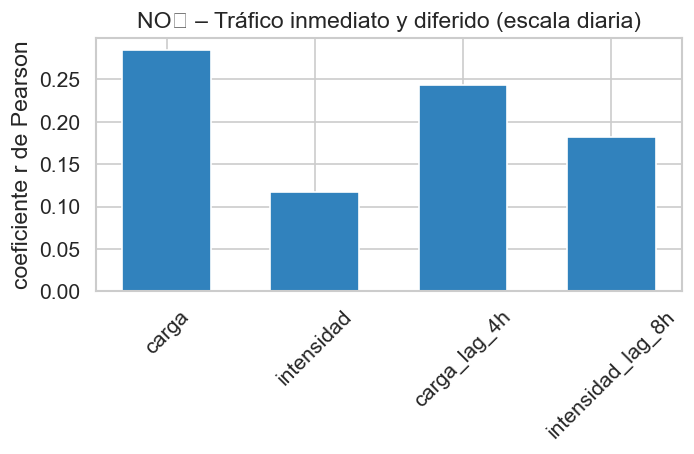

In [75]:
import matplotlib.pyplot as plt

# Top-4 coeficientes diarios de tráfico (inmediato y diferido)
coef_traf_daily = {
    "carga":             0.284776,
    "intensidad":        0.116823,
    "carga_lag_4h":     0.243862,
    "intensidad_lag_8h" :0.181739
}

fig, ax = plt.subplots(figsize=(6, 4))
vars_ = list(coef_traf_daily.keys())
vals_ = list(coef_traf_daily.values())

ax.bar(vars_, vals_, color="#3182bd", width=0.6)
ax.set_ylabel("coeficiente r de Pearson")
ax.set_title("NO₂ – Tráfico inmediato y diferido (escala diaria)")
ax.axhline(0, color="k", linewidth=.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_91827/2389805333.py:37: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.

/opt/anaconda3/envs/master_thesis/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.



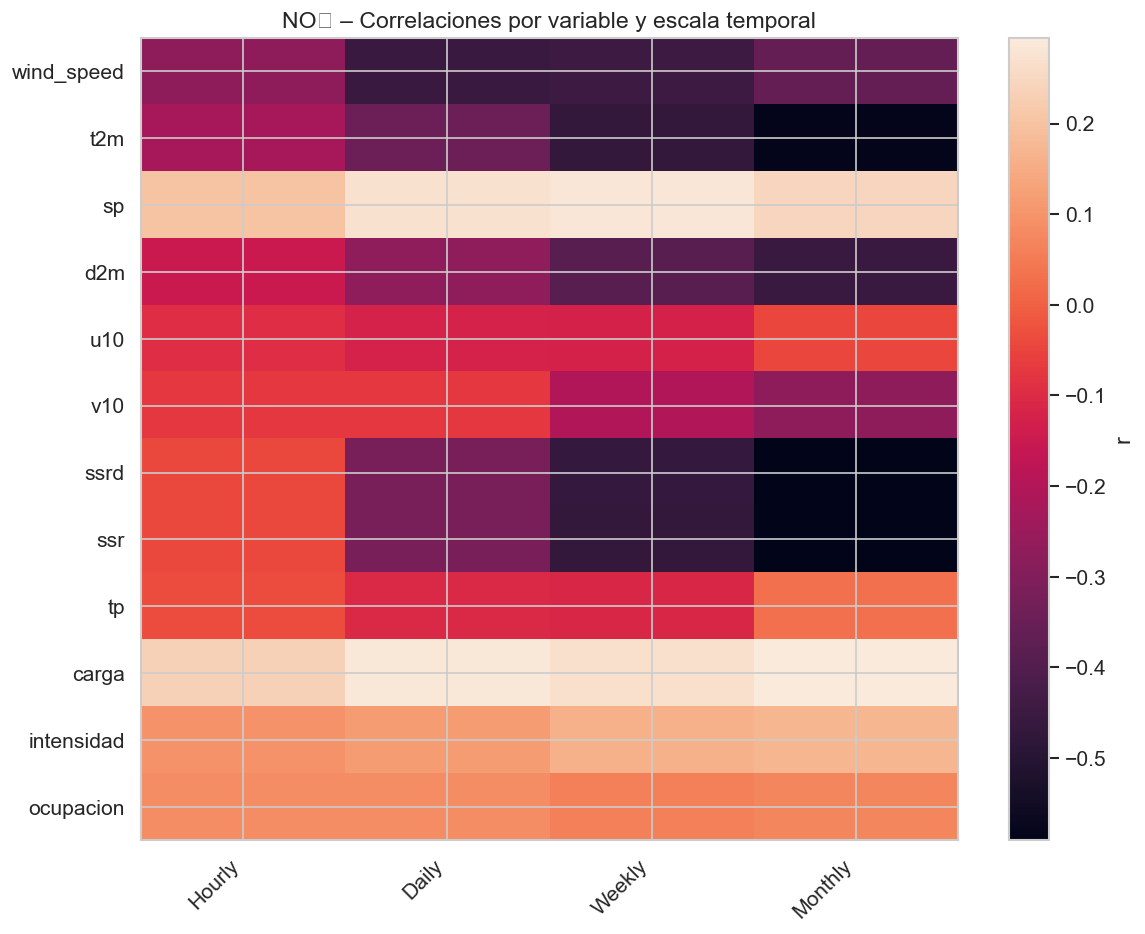

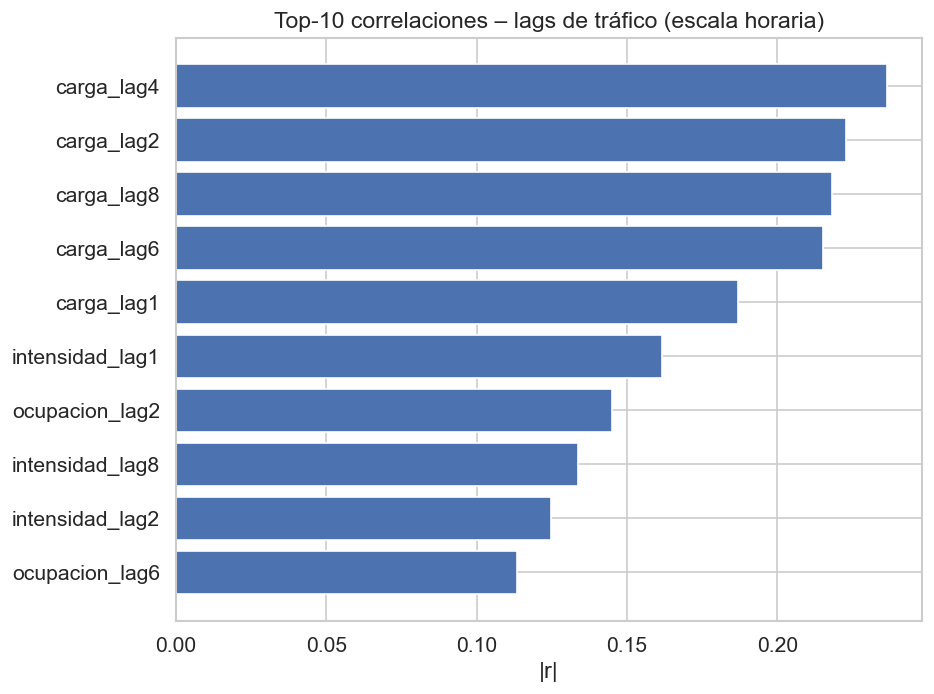

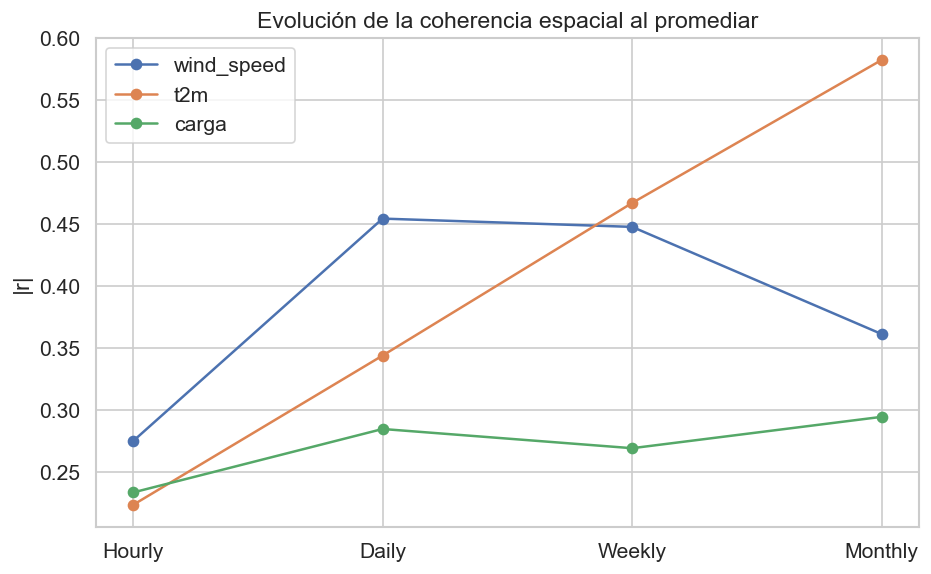

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------
# 1.  MATRIZ DE CORRELACIONES (heat-map)  ──────────────────────
# -------------------------------------------------------------
scales = ['Hourly', 'Daily', 'Weekly', 'Monthly']

data = {
    'wind_speed':  [-0.274995, -0.454421, -0.447741, -0.361306],
    't2m':         [-0.223554, -0.344001, -0.467038, -0.582364],
    'sp':           [0.203669,  0.270514,  0.281075,  0.244067],
    'd2m':         [-0.149280, -0.270173, -0.390226, -0.453680],
    'u10':         [-0.093101, -0.123294, -0.124814, -0.044959],
    'v10':         [-0.074386, -0.074191, -0.202395, -0.273132],
    'ssrd':        [-0.044212, -0.320813, -0.465959, -0.590907],
    'ssr':         [-0.041514, -0.319862, -0.466842, -0.587920],
    'tp':          [-0.034182, -0.105773, -0.110187,  0.029819],
    'carga':        [0.233593,  0.284776,  0.269285,  0.294577],
    'intensidad':   [0.095468,  0.116823,  0.161641,  0.170972],
    'ocupacion':    [0.086105,  0.083694,  0.062165,  0.072332],
}

corr_df = pd.DataFrame(data, index=scales).T

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_df.values, aspect='auto')

# Ejes y etiquetas
ax.set_xticks(np.arange(len(scales)))
ax.set_xticklabels(scales, rotation=45, ha="right")
ax.set_yticks(np.arange(len(corr_df.index)))
ax.set_yticklabels(corr_df.index)
ax.set_title("NO₂ – Correlaciones por variable y escala temporal")
plt.colorbar(im, ax=ax, label='r')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 2.  TOP-10 LAGS DE TRÁFICO  (barras horizontales) ────────────
# -------------------------------------------------------------
lags_hourly = {
    'carga_lag4':         0.236419,
    'carga_lag2':         0.222692,
    'carga_lag8':         0.218187,
    'carga_lag6':         0.215315,
    'carga_lag1':         0.186868,
    'intensidad_lag1':    0.161728,
    'ocupacion_lag2':     0.145186,
    'intensidad_lag8':    0.133773,
    'intensidad_lag2':    0.124750,
    'ocupacion_lag6':     0.113337,
    # resto omitido
}

lags_series = pd.Series(lags_hourly).abs().sort_values(ascending=True).tail(10)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(lags_series.index, lags_series.values)
ax.set_xlabel('|r|')
ax.set_title('Top-10 correlaciones – lags de tráfico (escala horaria)')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 3.  EVOLUCIÓN DE |r| CON LA ESCALA (líneas) ──────────────────
# -------------------------------------------------------------
variables = {
    'wind_speed': [-0.274995, -0.454421, -0.447741, -0.361306],
    't2m':        [-0.223554, -0.344001, -0.467038, -0.582364],
    'carga':       [0.233593,  0.284776,  0.269285,  0.294577],
}

fig, ax = plt.subplots(figsize=(8, 5))
for var, vals in variables.items():
    ax.plot(scales, np.abs(vals), marker='o', label=var)

ax.set_ylabel('|r|')
ax.set_title('Evolución de la coherencia espacial al promediar')
ax.legend()
plt.tight_layout()
plt.show()
